<a href="https://colab.research.google.com/github/saeedzou/DeepLearning1401-01/blob/main/Assignment%204/q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import json
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import skimage.io as io
from pycocotools.coco import COCO
from tqdm import tqdm
from torchvision.datasets.vision import VisionDataset
import os.path
from typing import Any, Callable, List, Optional, Tuple
!pip -q install timm
import timm
import string
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 7.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!wget http://images.cocodataset.org/zips/test2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip -q train2014.zip
!unzip -q val2014.zip
!unzip -q test2014.zip
!unzip -q annotations_trainval2014.zip
!rm -rf *.zip

--2023-02-01 16:28:34--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.49.220, 52.216.144.139, 52.216.163.11, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.49.220|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  33.8MB/s    in 7m 0s   

2023-02-01 16:35:34 (30.7 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

--2023-02-01 16:35:34--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.108.132, 52.216.187.3, 52.216.209.65, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.108.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================

We first begin by using COCO API to load the data and display a few images.

In [3]:
data_dir = '.'
data_split = 'train2014'
instances_path = os.path.join(data_dir, 'annotations', f'instances_{data_split}.json')
# Load the instances annotations for the specified data split and create an instance of the COCO class
coco = COCO(instances_path) 
# initialize the COCO API for caption annotations
captions_path = os.path.join(data_dir, 'annotations', f'captions_{data_split}.json')
coco_caps = COCO(captions_path)

ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=16.47s)
creating index...
index created!
loading annotations into memory...
Done (t=1.40s)
creating index...
index created!


Image ID:  117871
Image Height:  427
Image Width:  640
Image URL:  http://images.cocodataset.org/train2014/COCO_train2014_000000117871.jpg
Image File Name:  COCO_train2014_000000117871.jpg


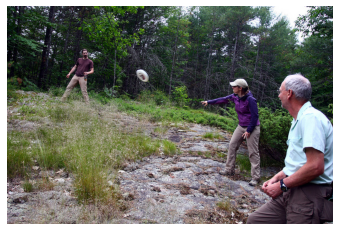

A woman throws a frisbee to a man in the woods.
Three people playing Frisbee in a clearing surrounded by trees..
Three men in the woods with an object sailing through the air between two.
A picture of people playing frisbee on a hill.
A woman is throwing a frisbee to a man in a rocky field.


In [4]:
# pick a random image and display it
anns_id = random.choice(ids)
anns = coco.anns[anns_id]
img_id = anns['image_id']
img = coco.loadImgs(img_id)[0]
I = io.imread(img['coco_url'])
print('Image ID: ', img_id)
print('Image Height: ', img['height'])
print('Image Width: ', img['width'])
print('Image URL: ', img['coco_url'])
print('Image File Name: ', img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()
# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img_id)
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [5]:
class Vocab:
    def __init__(self, annotations_file, start_token, end_token, unknown_token, pad_token, threshold):
        self.start_token = start_token
        self.end_token = end_token
        self.unknown_token = unknown_token
        self.threshold = threshold
        self.pad_token = pad_token

        with open(annotations_file, 'r') as f:
            data = json.load(f)

        all_captions = [ann['caption'].lower() for ann in data['annotations']]
        words = [word for caption in all_captions for word in caption.split()]
        word_counter = Counter(words)

        self.vocab = [word for word, count in word_counter.items() if count >= self.threshold]
        self.vocab = [self.start_token, self.end_token, self.unknown_token, self.pad_token] + self.vocab
        self.word_to_idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx_to_word = {idx: word for idx, word in enumerate(self.vocab)}

    def __len__(self):
        return len(self.vocab)

    def __call__(self, word):
        return self.word_to_idx.get(word, self.word_to_idx[self.unknown_token])

    def get_word_from_idx(self, idx):
        return self.idx_to_word[idx]

vocab = Vocab(annotations_file=captions_path, start_token='<sos>', end_token='<eos>', unknown_token='<unk>', pad_token='<pad>', threshold=5)
# print the size of the vocabulary
print('Vocabulary Size: ', len(vocab))
# print the first 10 words in the vocabulary
print('First 10 words in the vocabulary: ', vocab.vocab[:10])

Vocabulary Size:  11919
First 10 words in the vocabulary:  ['<sos>', '<eos>', '<unk>', '<pad>', 'a', 'very', 'clean', 'and', 'well', 'decorated']


## The CocoCaptioningDataset selects a random caption for each image and trains with that caption. The average image has 5 captions, so after 10 epochs, each caption is seen 2 times on average.

In [6]:
class CocoDetection(VisionDataset):
    """`MS Coco Detection <https://cocodataset.org/#detection-2016>`_ Dataset.

    It requires the `COCO API to be installed <https://github.com/pdollar/coco/tree/master/PythonAPI>`_.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.PILToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        transforms (callable, optional): A function/transform that takes input sample and its target as entry
            and returns a transformed version.
    """

    def __init__(
        self,
        root: str,
        annFile: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transforms, transform, target_transform)
        from pycocotools.coco import COCO

        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")

    def _load_target(self, id: int) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        target = [self._load_target(id)[i]['caption'] for i in range(len(self._load_target(id)))]

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target


    def __len__(self) -> int:
        return len(self.ids)

# create a CocoCaptioningDataset which takes the CocoDetection dataset as input and preprocesses the captions
class CocoCaptioningDataset(Dataset):
    def __init__(self, coco_detection_dataset, vocab, max_len=70):
        self.coco_detection_dataset = coco_detection_dataset
        self.vocab = vocab
        self.max_len = max_len

    def __getitem__(self, index):
        img, captions = self.coco_detection_dataset[index]
        # randomly select a caption
        captions = random.choice(captions)
        tokens = nltk.tokenize.word_tokenize(str(captions).lower())
        # remove punctuations 
        tokens = [word for word in tokens if word not in string.punctuation]
        caption = []
        caption.append(self.vocab(self.vocab.start_token))
        caption.extend(self.vocab(word) for word in tokens)
        caption.append(self.vocab(self.vocab.end_token))
        # pad the caption if it is less than max_len
        caption.extend([self.vocab(self.vocab.pad_token)] * (self.max_len - len(caption)))
        targets = torch.Tensor(caption).long()
        return img, targets
    def __len__(self):
        return len(self.coco_detection_dataset)
    
    def preprocess(self, caption):
        # convert all words to lowercase
        caption = [[word.lower() for word in caption.split()]]

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
coco_detection_dataset = CocoDetection(root='train2014', annFile=captions_path, transform=transform)
coco_captioning_dataset = CocoCaptioningDataset(coco_detection_dataset, vocab)
coco_captioning_dataloader = DataLoader(coco_captioning_dataset, batch_size=32, shuffle=True)

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [8]:
# define EncoderCNN which uses a pretrained ResNet50 from timm
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.resnet = timm.create_model('resnet50', pretrained=True)
        # freeze the weights of the pretrained model
        for param in self.resnet.parameters():
            param.requires_grad_(False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.embed_size = embed_size

    def forward(self, images):
        features = self.resnet(images)
        return features

# define DecoderRNN which takes the output of the EncoderCNN and predicts the next word in the caption
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        # remove the last word from the captions
        captions = captions[:, :-1]
        embeddings = self.embedding(captions)
        # concatenate the features and embeddings
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        outputs, _ = self.lstm(inputs)
        outputs = self.fc(outputs)
        return outputs

    def sample(self, inputs, states=None, max_len=70):
        sampled_ids = []
        for i in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.fc(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embedding(predicted)
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids

In [12]:
# define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyperparameters
embed_size = 256
hidden_size = 512
num_layers = 1
num_epochs = 7
learning_rate = 3e-4
batch_size = 32

# initialize the encoder and decoder
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)


In [13]:
coco_detection_val = CocoDetection(root='val2014', annFile="annotations/captions_val2014.json", transform=transform,)
coco_captioning_val = CocoCaptioningDataset(coco_detection_val, vocab)
coco_captioning_val_dataloader = DataLoader(coco_captioning_val, batch_size=1, shuffle=True)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


Epoch [0/7], Step [500/2587], Loss: 3.7342, Perplexity: 41.8553
Epoch [0/7], Step [1000/2587], Loss: 3.8788, Perplexity: 48.3649
Epoch [0/7], Step [1500/2587], Loss: 3.6499, Perplexity: 38.4723
Epoch [0/7], Step [2000/2587], Loss: 2.9049, Perplexity: 18.2626
Epoch [0/7], Step [2500/2587], Loss: 3.0590, Perplexity: 21.3057
<sos> a man riding a skateboard on a skateboard <eos>


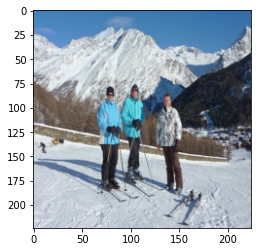

Epoch [1/7], Step [500/2587], Loss: 2.9418, Perplexity: 18.9505
Epoch [1/7], Step [1000/2587], Loss: 2.7665, Perplexity: 15.9034
Epoch [1/7], Step [1500/2587], Loss: 2.5161, Perplexity: 12.3799
Epoch [1/7], Step [2000/2587], Loss: 2.5683, Perplexity: 13.0436
Epoch [1/7], Step [2500/2587], Loss: 2.8585, Perplexity: 17.4345
<sos> a computer desk with a computer and a computer monitor <eos>


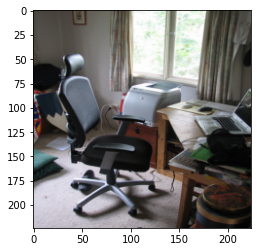

Epoch [2/7], Step [500/2587], Loss: 2.4963, Perplexity: 12.1376
Epoch [2/7], Step [1000/2587], Loss: 2.5422, Perplexity: 12.7078
Epoch [2/7], Step [1500/2587], Loss: 2.7654, Perplexity: 15.8855
Epoch [2/7], Step [2000/2587], Loss: 2.5955, Perplexity: 13.4035
Epoch [2/7], Step [2500/2587], Loss: 2.6875, Perplexity: 14.6943
<sos> a large elephant standing in a field <eos>


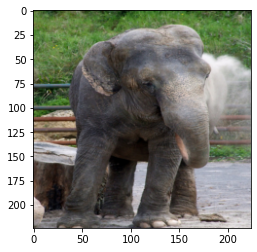

Epoch [3/7], Step [500/2587], Loss: 2.3136, Perplexity: 10.1112
Epoch [3/7], Step [1000/2587], Loss: 2.7321, Perplexity: 15.3653
Epoch [3/7], Step [1500/2587], Loss: 2.6107, Perplexity: 13.6079
Epoch [3/7], Step [2000/2587], Loss: 2.2250, Perplexity: 9.2533
Epoch [3/7], Step [2500/2587], Loss: 2.5099, Perplexity: 12.3041
<sos> a bunch of bananas hanging from a ceiling <eos>


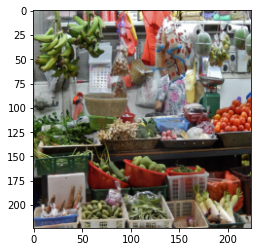

Epoch [4/7], Step [500/2587], Loss: 2.2385, Perplexity: 9.3789
Epoch [4/7], Step [1000/2587], Loss: 2.5972, Perplexity: 13.4259
Epoch [4/7], Step [1500/2587], Loss: 2.3437, Perplexity: 10.4194
Epoch [4/7], Step [2000/2587], Loss: 2.1852, Perplexity: 8.8928
Epoch [4/7], Step [2500/2587], Loss: 2.3844, Perplexity: 10.8529
<sos> a group of people standing on a street near a building <eos>


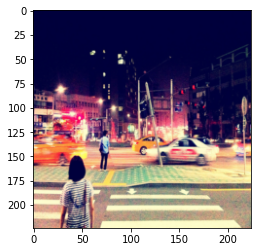

Epoch [5/7], Step [500/2587], Loss: 2.4209, Perplexity: 11.2565
Epoch [5/7], Step [1000/2587], Loss: 2.3163, Perplexity: 10.1385
Epoch [5/7], Step [1500/2587], Loss: 2.2340, Perplexity: 9.3375
Epoch [5/7], Step [2000/2587], Loss: 2.0316, Perplexity: 7.6262
Epoch [5/7], Step [2500/2587], Loss: 2.3512, Perplexity: 10.4980
<sos> a woman playing tennis is swinging her racket <eos>


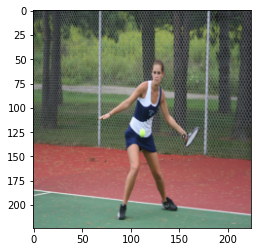

Epoch [6/7], Step [500/2587], Loss: 2.4883, Perplexity: 12.0405
Epoch [6/7], Step [1000/2587], Loss: 2.0897, Perplexity: 8.0822
Epoch [6/7], Step [1500/2587], Loss: 2.5388, Perplexity: 12.6641
Epoch [6/7], Step [2000/2587], Loss: 2.0792, Perplexity: 7.9977
Epoch [6/7], Step [2500/2587], Loss: 2.3299, Perplexity: 10.2769
<sos> a train is traveling on a train track <eos>


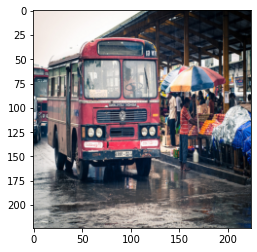

In [14]:
# initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab(vocab.pad_token))
params = list(decoder.parameters()) + list(encoder.resnet.fc.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

# train the model
total_step = len(coco_captioning_dataloader)
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    for i, (images, captions) in enumerate(coco_captioning_dataloader):
        images = images.to(device)
        captions = captions.to(device)
        features = encoder(images)
        outputs = decoder(features, captions)
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 500 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, num_epochs, i+1, total_step, loss.item(), np.exp(loss.item())))
        # show an image from the validation set and its predicted caption and ground truth caption every 1000 steps
    
    # evaluate the model
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # get a random image from the validation set
        images, captions = next(iter(coco_captioning_val_dataloader))
        images = images.to(device)
        captions = captions.to(device)
        # select the first image and its caption
        image = images[0].unsqueeze(0)
        caption = captions[0].unsqueeze(0)
        # get the predicted caption
        feature = encoder(image)
        sampled_ids = decoder.sample(feature)
        sampled_ids = sampled_ids[0].cpu().numpy()
        # convert the predicted caption from word ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.get_word_from_idx(word_id)
            sampled_caption.append(word)
            if word == '<eos>':
                break
        sentence = ' '.join(sampled_caption)
        # show the image and the predicted caption
        image = image.squeeze(0)
        image = image.permute(1, 2, 0).cpu().numpy()
        image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
        image = image.clip(0, 1)
        plt.imshow(image)
        print(sentence)
        plt.show()

## We can see that even after 3 epochs, the model is almost capable of generating captions for images it hasn't seen during training phase.

<sos> a woman holding an umbrella while standing in the rain <eos>


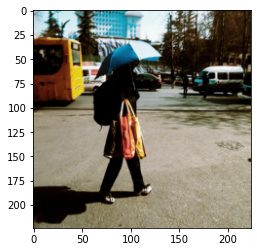

<sos> a computer screen with a keyboard and a mouse <eos>


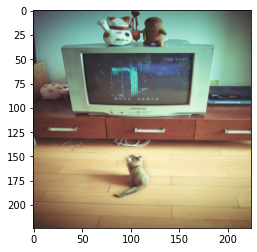

<sos> a person on a snowboard in the air <eos>


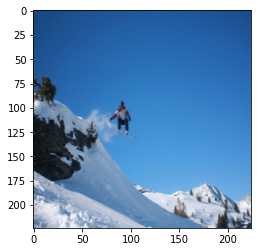

<sos> a zebra is standing in the grass by a tree <eos>


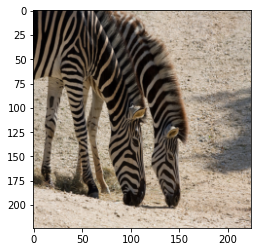

<sos> a bunch of people are standing in a room <eos>


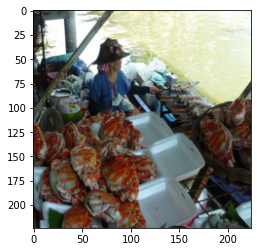

<sos> a boat is docked on the water near a lake <eos>


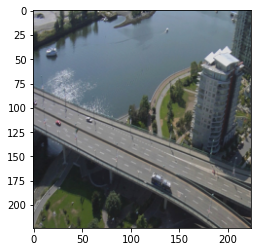

<sos> a toilet with a lot of hot dogs on it <eos>


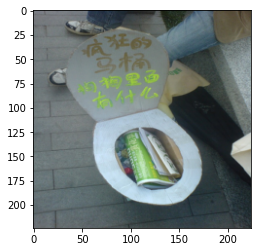

<sos> a group of people standing around a table with food <eos>


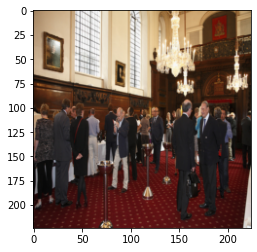

<sos> a train is traveling down the tracks near a forest <eos>


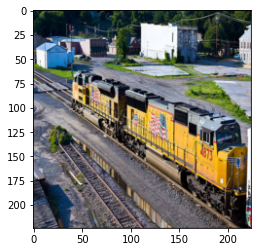

<sos> a street sign on a pole in the city <eos>


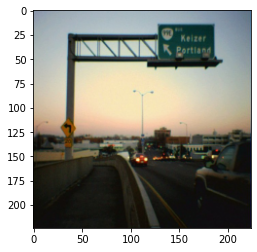

In [16]:
# evaluate the model
for i in range(10):
  with torch.no_grad():
      # get a random image from the validation set
      images, captions = next(iter(coco_captioning_val_dataloader))
      images = images.to(device)
      captions = captions.to(device)
      # select the first image and its caption
      image = images[0].unsqueeze(0)
      caption = captions[0].unsqueeze(0)
      # get the predicted caption
      feature = encoder(image)
      sampled_ids = decoder.sample(feature)
      sampled_ids = sampled_ids[0].cpu().numpy()
      # convert the predicted caption from word ids to words
      sampled_caption = []
      for word_id in sampled_ids:
          word = vocab.get_word_from_idx(word_id)
          sampled_caption.append(word)
          if word == '<eos>':
              break
      sentence = ' '.join(sampled_caption)
      # show the image and the predicted caption
      image = image.squeeze(0)
      image = image.permute(1, 2, 0).cpu().numpy()
      image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
      image = image.clip(0, 1)
      plt.imshow(image)
      print(sentence)
      plt.show()